In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


### Análise Exploratória

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


#### Retira Valores Nulos

In [4]:
# Retira linhas que tenham algum valor Null

df.dropna(inplace=True)

In [5]:
# Certifica se ainda há algum valor Null

df.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

#### Converte Tipos

In [6]:
# Transforma o tipo de Reviews, Installs e Price para Numérico

df['Reviews'] = pd.to_numeric(df['Reviews'])
df['Installs'] = pd.to_numeric(df['Installs'].apply(lambda x: x[:-1].replace(',', '')))
df['Price'] = pd.to_numeric(df['Price'].apply(lambda x: x.replace('$', '')))

In [7]:
# Transformar o tipo de Size para Numérico e em Kilobytes

df['Size KB'] = df[df['Size'] != 'Varies with device']['Size'].apply(lambda x: float(x[:-1]) * 1000 if x[-1] == 'M' else float(x[:-1]))

df.drop('Size',axis = 1, inplace=True)

In [8]:
# Transforma o valor Nan, que anteriormente era 'Varies with device', na média da sua respectiva Category

category_size_mean = df[~np.isnan(df['Size KB'])].groupby('Category')[['Size KB']].mean().squeeze()

size_without_nan = []
for idx, row in df.iterrows():
    if np.isnan(row['Size KB']):
        size_without_nan.append(category_size_mean[row['Category']])
    else:
        size_without_nan.append(row['Size KB'])
        
df['Size KB'] = size_without_nan

In [9]:
df.describe()

,Rating,Reviews,Installs,Price,Size KB
count,9360.000000,9.360000e+03,9.360000e+03,9360.000000,9360.000000
mean,4.191838,5.143767e+05,1.790875e+07,0.961279,22495.626426
std,0.515263,3.145023e+06,9.126637e+07,15.821640,21669.031913
min,1.000000,1.000000e+00,1.000000e+00,0.000000,8.500000
25%,4.000000,1.867500e+02,1.000000e+04,0.000000,6600.000000
50%,4.300000,5.955000e+03,5.000000e+05,0.000000,16000.000000
75%,4.500000,8.162750e+04,5.000000e+06,0.000000,30000.000000
max,5.000000,7.815831e+07,1.000000e+09,400.000000,100000.000000


#### Analisa Possíveis Outliers

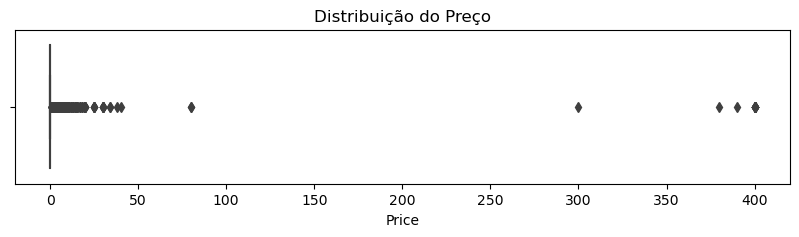

In [10]:
# A diferença entre o min e o max da feature Price aparenta ser bastante desigual

plt.figure(figsize=(10,2))

sns.boxplot(data=df, x='Price')
plt.title("Distribuição do Preço");

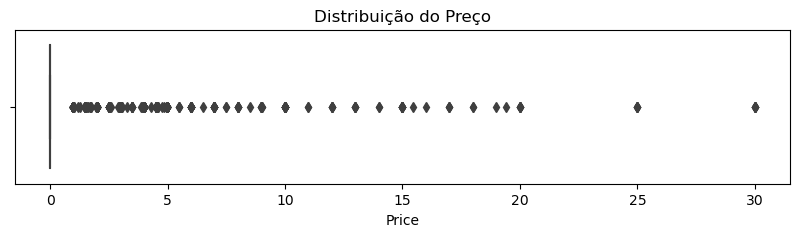

In [11]:
# Remove valores abaixo e acima das fronteiras estabelecidas na feature Price

price_mean = df['Price'].mean()
price_std = df['Price'].std()

border_down = price_mean - 2 * price_std
border_up = price_mean + 2 * price_std

indices = df[(df['Price'] < border_down) | (df['Price'] > border_up)].index
df.drop(indices, inplace=True)

plt.figure(figsize=(10,2))

sns.boxplot(data=df, x='Price')
plt.title("Distribuição do Preço");

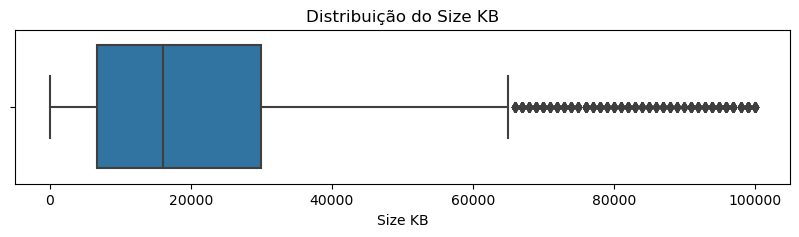

In [12]:
# A diferença entre o min e o max da feature Size aparenta ser bastante desigual, porém não foram considerados Outliers

plt.figure(figsize=(10,2))

sns.boxplot(data=df, x='Size KB')
plt.title("Distribuição do Size KB");

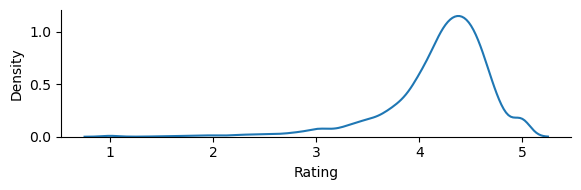

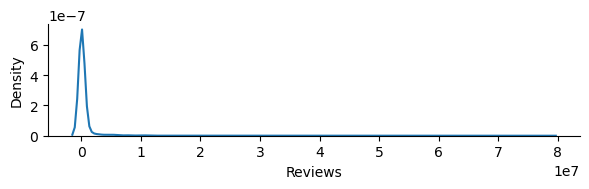

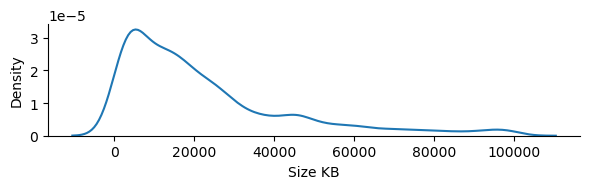

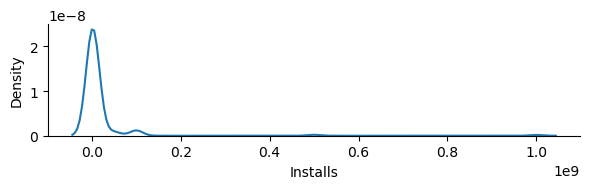

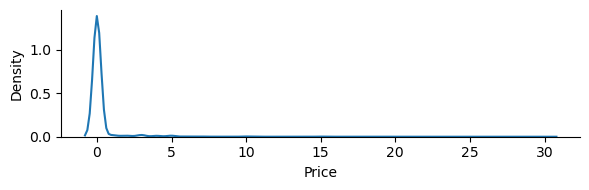

In [13]:
# Verifica as distribuições de algumas features

cols = ['Rating', 'Reviews', 'Size KB', 'Installs', 'Price']

for col in cols:
    sns.displot(df, x=col, kind="kde", height=2, aspect=3)

C:\Users\Vlademir\AppData\Local\Temp\ipykernel_13036\647028481.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='RdYlGn')


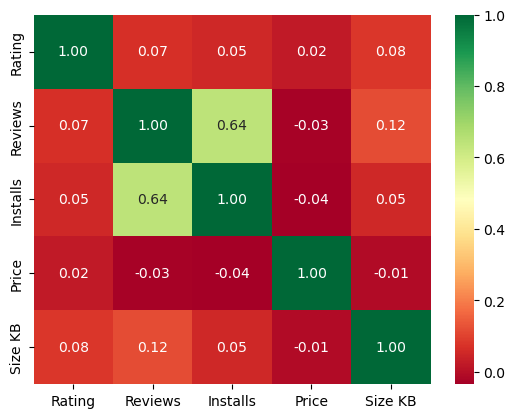

In [14]:
# Analisa a correlação entre cada feature a partir de um Mapa de Calor

sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='RdYlGn')

plt.show()

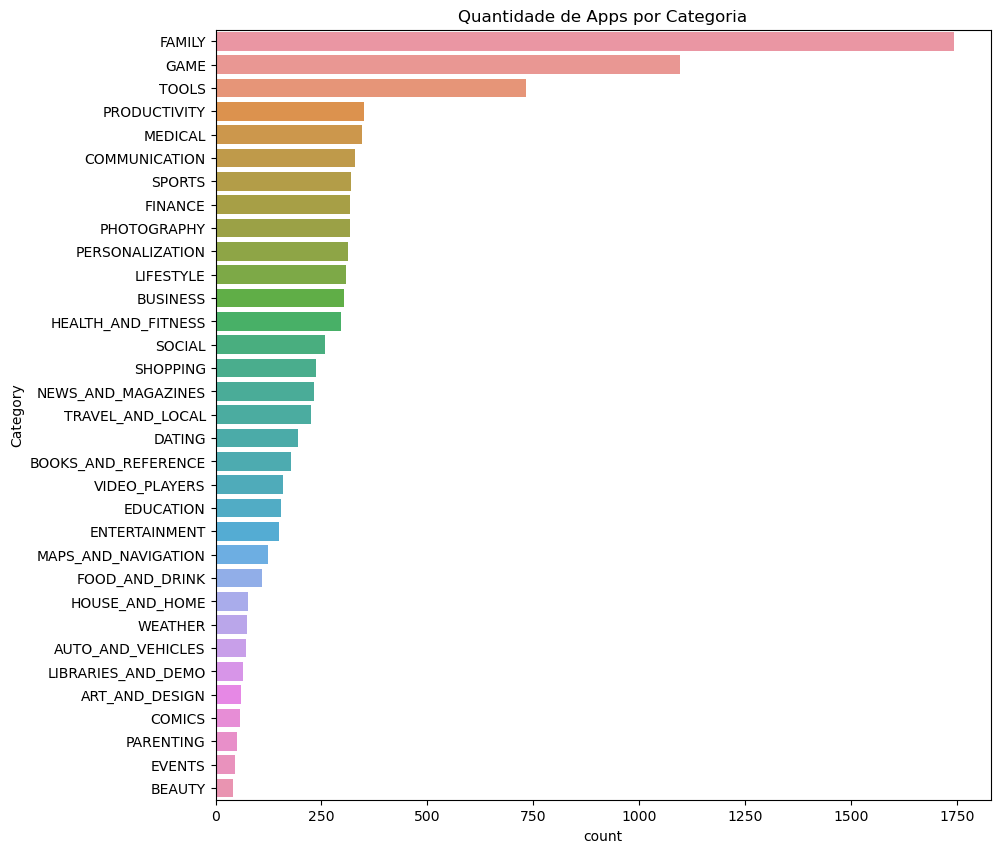

In [15]:
# Quantidade de apps por categoria

plt.figure(figsize=(10,10))

sns.countplot(y=df['Category'], order=df['Category'].value_counts().index)
plt.title("Quantidade de Apps por Categoria");

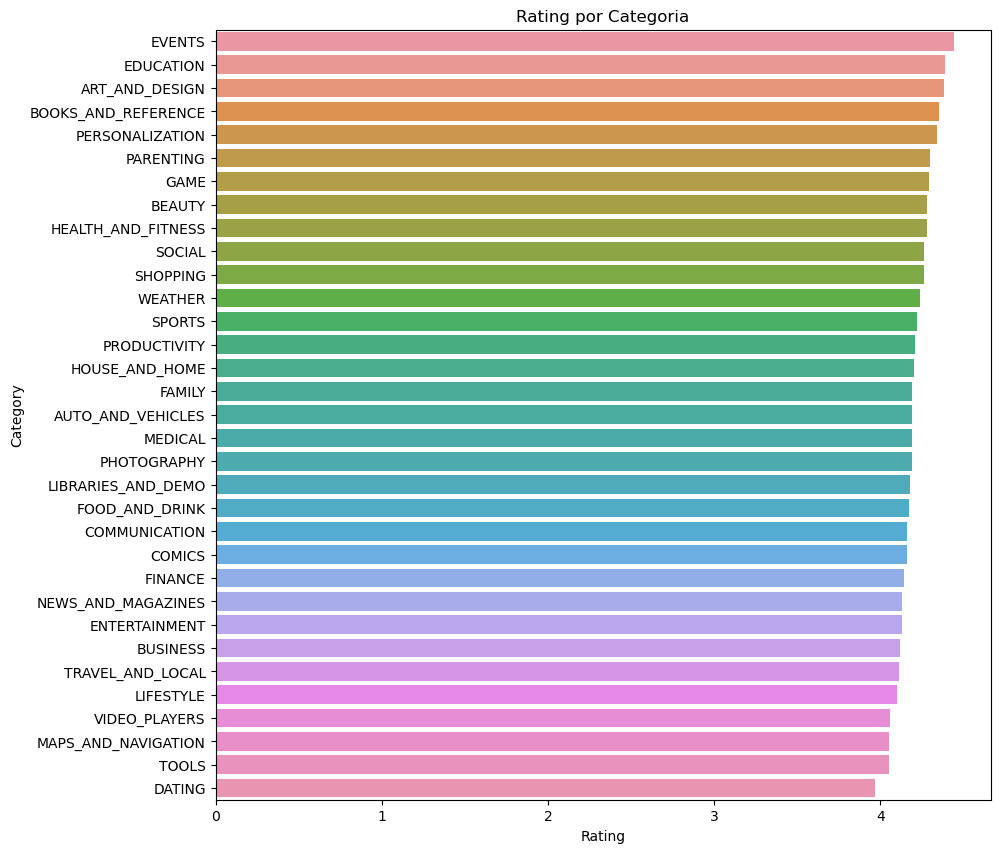

In [16]:
# Média de Rating das categorias

category_rating_mean = df.groupby('Category')[['Rating']].mean().squeeze().apply(lambda x: round(x, 2)).sort_values(ascending=False)

plt.figure(figsize=(10,10))

sns.barplot(x=category_rating_mean, y=category_rating_mean.index)
plt.title("Rating por Categoria");

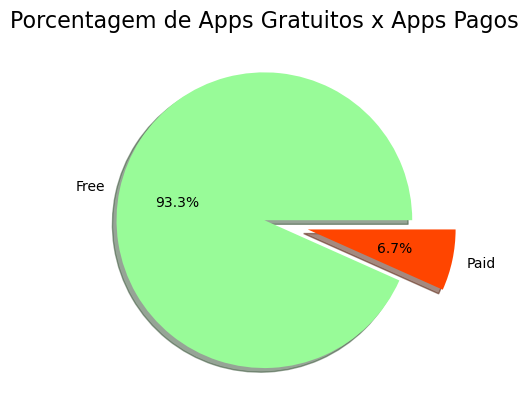

In [17]:
# Porcentagem Apps Gratuitos x Apps Pagos

plt.pie(df['Type'].value_counts(), labels=df['Type'].value_counts().index, autopct='%1.1f%%', 
        shadow=True, explode=[0, 0.3], colors=["palegreen","orangered"])
plt.title('Porcentagem de Apps Gratuitos x Apps Pagos', size = 16)

plt.show() 

In [18]:
df['Price'].describe()

count    9339.000000
mean        0.302149
std         1.669951
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        29.990000
Name: Price, dtype: float64

In [19]:
# Muitos gêneros possuem apenas uma aparição, então vou agrupá-los nos seus gêneros principais, deixando seu subgênero de fora
# (Ex.: Strategy;Creativity -> Gênero;Subgênero)

df['Genres'] = df['Genres'].apply(lambda x: x.split(';')[0])

In [20]:
# Muda o gênero Music & Video para Music, pois só tem um app do gênero Music & Video

df['Genres'].replace('Music & Audio', 'Music', inplace=True)

Text(0.5, 1.0, 'Quantidade de Apps por Gênero')

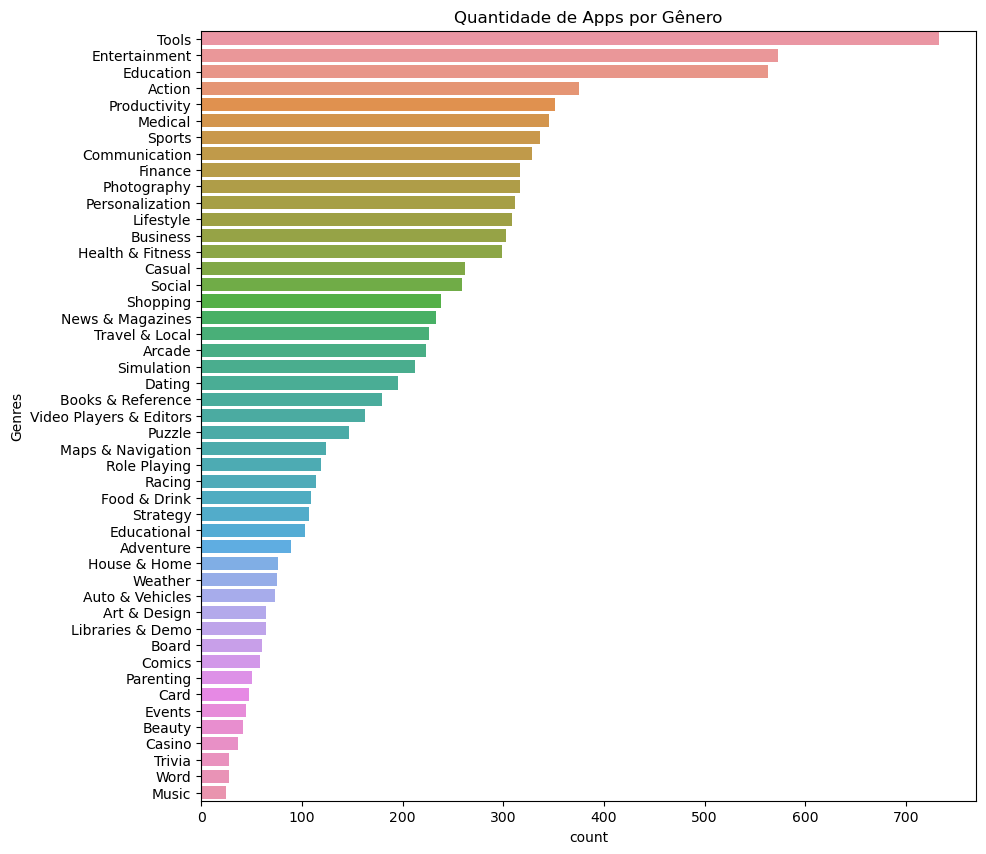

In [21]:
# Quantidade de apps por gênero

plt.figure(figsize=(10,10))

sns.countplot(y=df['Genres'], order=df['Genres'].value_counts().index)
plt.title("Quantidade de Apps por Gênero")

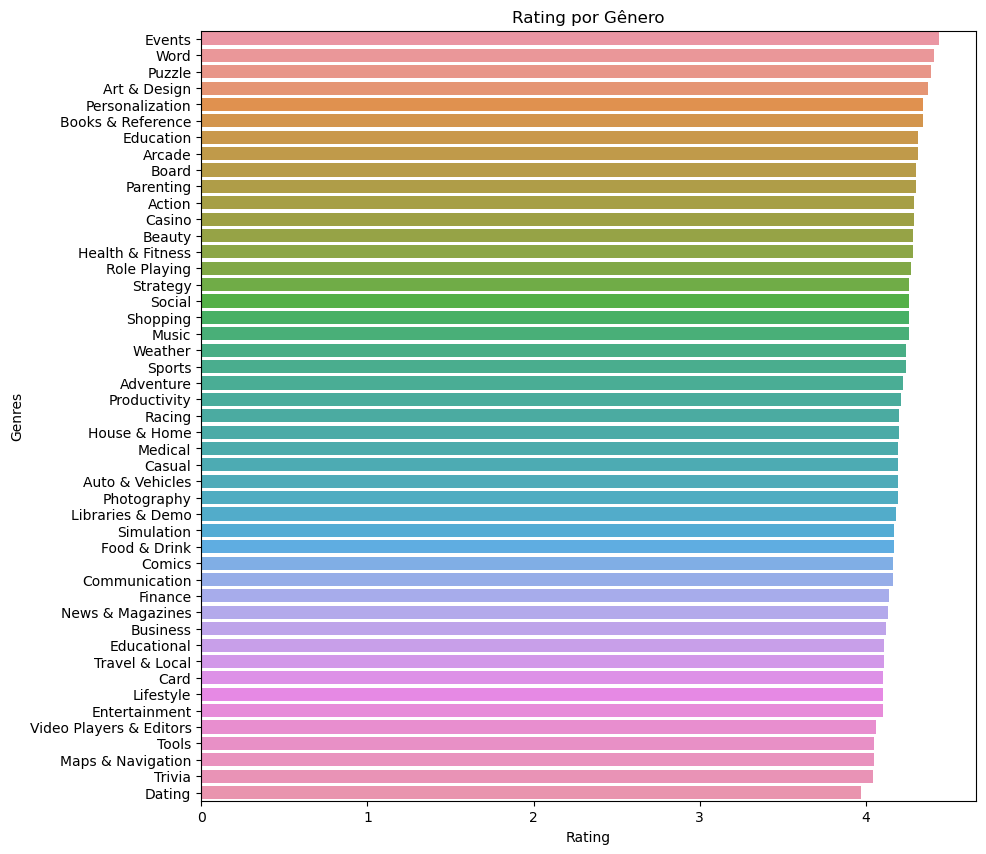

In [22]:
# Média de Rating dos gêneros

genre_rating_mean = df.groupby('Genres')[['Rating']].mean().squeeze().apply(lambda x: round(x, 2)).sort_values(ascending=False)

plt.figure(figsize=(10,10))

sns.barplot(x=genre_rating_mean, y=genre_rating_mean.index)
plt.title("Rating por Gênero");

In [23]:
# Remove a avaliação 'Unrated', pois há apenas uma

df = df[df['Content Rating'] != 'Unrated']

### Tratamendo de dados categóricos

In [24]:
df = pd.get_dummies(df, columns= ['Category', 'Type', 'Content Rating', 'Genres'])

### Seleção e Treinamento

In [25]:
# Aplica uma Log Transformation nas variáveis independentes, com o intuito de torná-los os mais "normais" possíveis ("normais" no sentido de próximo da Distribuição Normal)

Y = df['Price']
X = df.loc[:, df.columns != 'Price'].select_dtypes(include='number')

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [26]:
log_lin_reg = Pipeline(steps=[
    ('log', FunctionTransformer(lambda x: np.log(x + 1))),
    ('lin_reg', LinearRegression())
])

log_lin_reg.fit(x_train, y_train)

predictions = log_lin_reg.predict(x_test)

print('RMSE: R$ {:.2f}'.format(round(np.sqrt(mean_squared_error(y_test, predictions)), 4)))

RMSE: R$ 1.16


### Previsão e Avaliação do Modelo

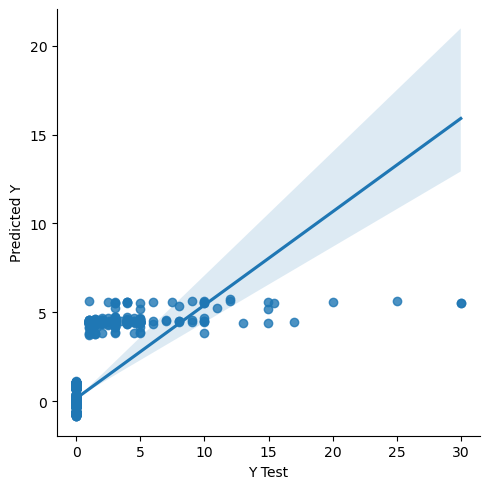

In [27]:
y_comparation = pd.DataFrame({ 'Y Test': y_test, 'Predicted Y': predictions })

sns.lmplot(data=y_comparation, x='Y Test', y='Predicted Y')

False


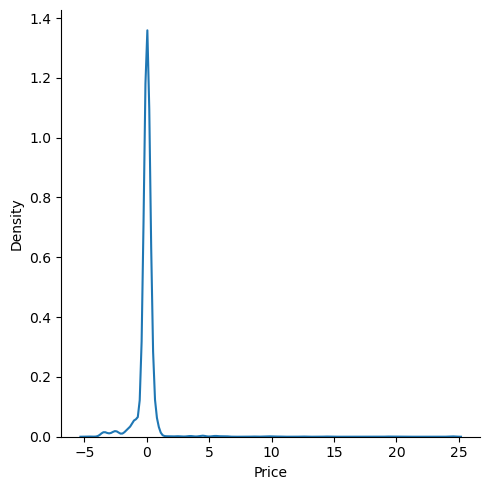

In [28]:
# Os resíduos não seguem uma Distribuição Normal, indicando que o modelo de Regressão Linear não explica todas as tendências no conjunto de dados

print(shapiro(y_test - predictions)[1] > 0.05)
sns.displot(y_test - predictions, kind="kde")

### Random Forest

In [29]:
rand_for = RandomForestRegressor()

rand_for.fit(x_train, y_train)

predictions = rand_for.predict(x_test)

rmse = mean_squared_error(y_test, predictions) ** (1/2)

print('RMSE: R$ {:.2f}'.format(rmse))

RMSE: R$ 0.96
